In [0]:
import numpy as np
from scipy.special import eval_legendre
from numpy.polynomial.legendre import legroots
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate

# Question 1

In order to compute 
$$\lambda_n(x) = \sum_{k=0}^n|\phi_{n,k}(x)|$$  

We first need to create a function to compute the $k^{th}$ Lagrange coefficient.  
We define this below.

In [0]:
def LagrangeCoeff(xs, j, x):
  result = 1.0
  for m in range(len(xs)):
    if m != j:
      result *= ((x - xs[m]) / (xs[j] - xs[m]))
      
  return result


def Lagrange(xs, x):
  return sum(abs(LagrangeCoeff(xs, j, x)) for j in range(len(xs)))

We can now compute $\|L_n\|$ by taking the maximum of $\lambda_n(x)$ out of $x = \pm1$, which we do below. We use Chebyshev nodes to get the $n+1$ nodes between $-1$ and $1$.


In [0]:
def chebyshev(a, b, n, k):
    return 0.5*(a + b) + 0.5*(b - a)*np.cos((2*k - 1) / (2*n) * np.pi)

def chebyshev_nodes(a, b, n):
    return np.array([chebyshev(a,b,n,k) for k in range(1, n+1)][::-1])
  
  

def normLn(n):
  xs = chebyshev_nodes(-1,1,n)
  return max(Lagrange(xs, -1), Lagrange(xs, 1))

We can now plot $n$ vs $\|L_n\|$.

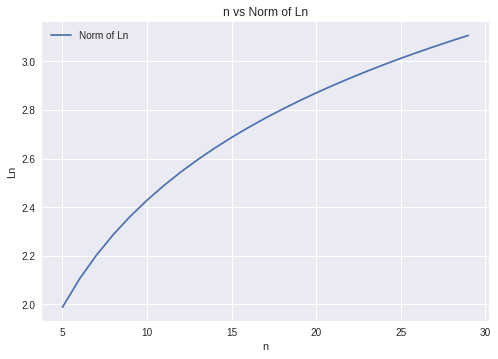



Norm of Ln can be approximated by 1.151*log(n)


In [4]:
ns = list(range(5, 30))
normLns = [normLn(n) for n in ns]

def c_log(c, n):
  return c*np.log(n)

c, _ = curve_fit(c_log, ns, normLns)

plt.plot(ns, normLns, label="Norm of Ln")
plt.title("n vs Norm of Ln")
plt.xlabel("n")
plt.ylabel("Ln")
plt.legend()
plt.show()

print("\n\nNorm of Ln can be approximated by {:.3f}*log(n)".format(c[0]))

As we can see above, $\|L_n\|$ can be approximated by $Clog(n)$ where $C \approx 1.151$.

# Question 2

We start by implementing the derivative of $\phi_{n,k}(x)$, which will be used to compute the maxima.

In [0]:
def derivative_lagrange_elem(xs,k,x):
  result = 1.0
  for m in range(len(xs)):
    if m != k:
      p = 1.0 / (xs[m] - xs[k])
      for i in range(len(xs)):
        if i != m and i != k:
          p *= (x - xs[i]) / (xs[m] - xs[i])
      result += p
      
  return result


def gradient_lagrange_elem(xs, x):
  return np.array([derivative_lagrange_elem(xs, k, x) for k in range(len(xs))])


def lagrange_derivative(xs, x):
  l_basis = np.array([LagrangeCoeff(xs, k, x) for k in range(len(xs))])
  return sum(gradient_lagrange_elem(xs, x) * l_basis / np.abs(l_basis))

Next, we implement the secant method to compute the maxima.

In [0]:
def secantMethod(df, a, b, epsilon=1e-5, maxIterations=100):
  for _ in range(maxIterations):
    c = b - df(b) * ((b - a) / (df(b) - df(a)))
    
    if (c-b) < epsilon:
      return c
    
    a, b = b, c

  return c

Using the above, we can now compute $\|L_n\|$ for equidistant nodes.

In [0]:
def Ln_equidistant(n):
  xs = np.linspace(-1,1,n+1)
  l = lambda x: Lagrange(xs, x)
  dl = lambda x: lagrange_derivative(xs, x)
  
  a1 = 0.5*(xs[0] + xs[1])
  b1 = a1 + (a1/5)
  possible_max = secantMethod(dl, a1, b1)
  
  a2 = 0.5*(xs[-1] + xs[-2])
  b2 = 1.2*a2
  other_max = secantMethod(l, a2, b2)
    
  return max(l(possible_max), l(other_max))

We can now plot $n$ vs $\|L_n\|$ using equidistant nodes.

Norm Ln can be approximated by 1.712^n


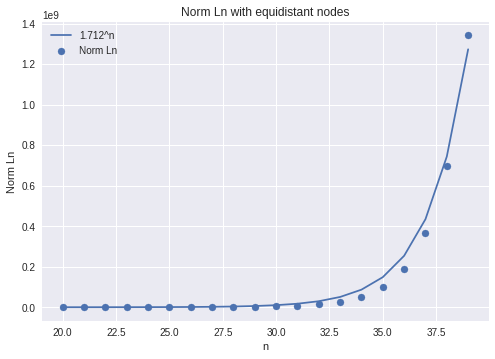

In [8]:
ns = list(range(20, 40))
normLns = [Ln_equidistant(n) for n in ns]


def func(n, c):
    return c**n

c, _ = curve_fit(func, ns, normLns)
c = c[0]
print("Norm Ln can be approximated by {:.3f}^n".format(c))

plt.scatter(ns, normLns, label="Norm Ln")
plt.plot(ns, [func(n,c) for n in ns], label="{:.3f}^n".format(c))
plt.legend()
plt.title('Norm Ln with equidistant nodes')
plt.xlabel('n')
plt.ylabel('Norm Ln')
plt.show()

As we can see from the above graph, $n \mapsto 1.712^n$ is a good approximation for $n \mapsto \|L_n\|$.   
The experimental result, $C = 1.712$, is close but not exactly equal to $2$.

# Question 3

We now compute $\|S_n\|$ using Chebyshev truncation,  

$$\|S_n\| = \int_0^\pi\left|\frac{sin((n + \frac{1}{2})\theta)}{2sin(\frac{1}{2}\theta)}\right|d\theta$$

To do this, we first define the function 

$$\theta \mapsto \left|\frac{sin((n + \frac{1}{2})\theta)}{2sin(\frac{1}{2}\theta)}\right|$$

In [0]:
def sn_chebyshev(n, theta):
  return abs(
      np.sin((n + 0.5)*theta) / 2*np.sin(0.5*theta)
  )

Since the function is highly irregular, especially for large $n$, we will put extra effort into computing good nodes.  
We will find all of the roots of $sin((n + \frac{1}{2})\theta)$, and use these as the nodes. We then add the endpoints to this list. However, since the function is not defined at $0$, we add $10^{-8}$ instead. We then compute the Chebyshev nodes between each consecutive pair.
This way, the function is smooth between any consecutive nodes.

In [0]:
def findNodes(n):
  zeros = [(np.pi * k) / (n + 0.5) for k in range(1, n+1)]
  initial_nodes = [1e-8] + zeros + [np.pi]
  
  nodes = np.array([1e-8])
  for i in range(len(initial_nodes)-1):
    nodes = np.append(nodes, chebyshev_nodes(initial_nodes[i], initial_nodes[i+1], max(3,n)))
  
  return nodes

Next, we define the quadrature. For this we will use trapezoidal quadrature.

In [0]:
def trapezoidal_step(f, a, b):
  return 0.5*(f(a) + f(b)) * (b - a)

def trapezoidal(f, xs):
  answer = 0.0
  for i in range(len(xs) - 1):
    answer += trapezoidal_step(f, xs[i], xs[i+1])
    
  return answer

We're now ready to compute the integral, and hence $\|S_n\|$.

In [0]:
def normSn(n):
  nodes = findNodes(n)
  sn = lambda theta: sn_chebyshev(n, theta)
  return trapezoidal(sn, nodes)

Now we can plot the graph of $n$ vs $\|S_n\|$ and find $C$ such that $\|S_n\| \approx C \cdot log(n)$.

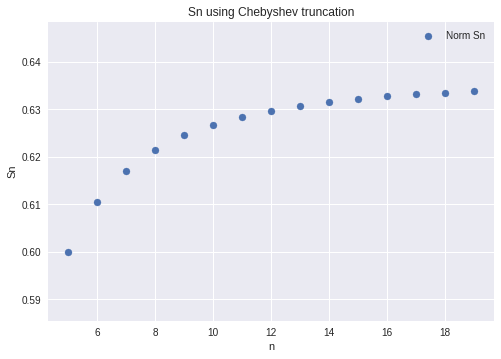



Sn can be approximated by 0.253*log(n)


In [13]:
ns = list(range(5, 20))
normSns = [normSn(n) for n in ns]

def f(n, c):
  return c*np.log(n)


c, _ = curve_fit(f, ns, normSns)
c = c[0]

plt.scatter(ns, normSns, label="Norm Sn")
#plt.plot(ns, [f(n, c) for n in ns], label="{:.2f}*log(n)".format(c))
plt.legend()
plt.xlabel("n")
plt.ylabel("Sn")
plt.title("Sn using Chebyshev truncation")
plt.show()

print("\n\nSn can be approximated by {:.3f}*log(n)".format(c))

# Question 4

We first define a function to compute 

$$\sum_{k=0}^na_kP_k(x)$$ 

From the theory assignment, we know that $a_k = k + \frac{1}{2} \ \forall \ k$

In [0]:
def f_sn(x, n):
  return sum((k + 0.5) * eval_legendre(k, x) for k in range(n+1))

Since this function is highly irregular, we take special care when computing the nodes. To ensure that the function is smooth between each consecutive pair of nodes, we use the zeros of the function Legendre function. We then add the endpoints of the integral, and use Chebyshev nodes between consecutive node.

In [0]:
def computeNodes(n):
  aks = [k + 0.5 for k in range(n+1)]
  zeros = legroots(aks)
  initial_nodes = [-1] + zeros.tolist() + [1]
  nodes = []
  for i in range(len(initial_nodes)-1):
    nodes += chebyshev_nodes(initial_nodes[i], initial_nodes[i+1], max(3, n)).tolist()
  return nodes
  

We use composite trapezoidal quadrature to approximate the integral, which is defnied above. We use Chebyshev nodes.

In [0]:
def NormSn(n):
  xs = computeNodes(n)
  #print(xs)
  f = lambda x: abs(f_sn(x, n))
  return trapezoidal(f, xs)

We can now plot $\|S_n\|$ against $n$.

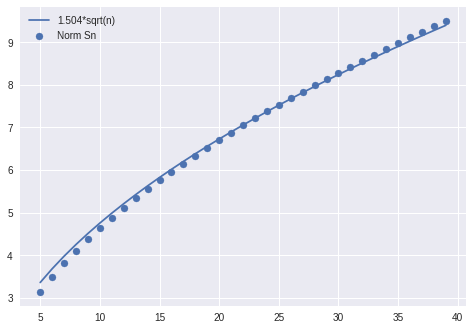



Sn can be approximated by 1.504*sqrt(n)


In [17]:
ns = list(range(5,40))
normSns = [NormSn(n) for n in ns]


def f(n, c):
  return c*np.sqrt(n)


c, _ = curve_fit(f, ns, normSns)
c = c[0]

plt.scatter(ns, normSns, label="Norm Sn")
plt.plot(ns, [f(n, c) for n in ns], label='{:.3f}*sqrt(n)'.format(c))
plt.legend()
plt.show()


print("\n\nSn can be approximated by {:.3f}*sqrt(n)".format(c))

As we can see above, $\|S_n\| \approx C \cdot \sqrt{n}$ where $C = 1.504$.

# Question 5

In order to compute $\|Q_n\|$, we first need to be able to compute $\omega_k = \int_0^1\phi_{n,k}(x)dx$. We implement this below.

In [0]:
def wk(n, k):
  nodes = np.linspace(0,1,n+1)
  f = lambda x: LagrangeCoeff(nodes, k, x)
  
  integral_nodes = chebyshev_nodes(0,1, max(5, 2*n))
  return trapezoidal(f, integral_nodes)

Using the quadrature implementations from above, we can now compute $\|Q_n\|$.

In [0]:
def normQn(n):
  return sum(abs(wk(n, k)) for k in range(n+1))

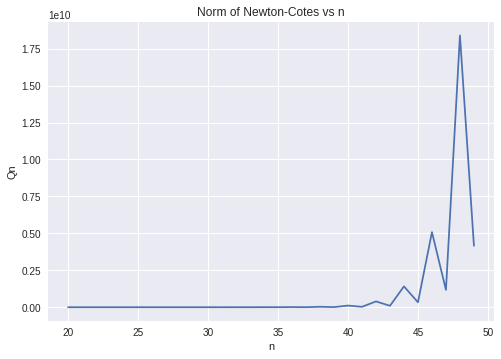

In [20]:
ns = list(range(20,50))
normQns = [normQn(n) for n in ns]


plt.plot(ns, normQns, label="Qn")
plt.xlabel("n")
plt.ylabel("Qn")
plt.title("Norm of Newton-Cotes vs n")
plt.show()

We can see that $\|Q_n\|$ grows with $n$ (although not monotonically). We therefore have that $Q_n(f) \not\to I(f)$ as $n \to \infty$.

It looks like $n \mapsto \|Q_n\|$ has a different underlying function for even and odd $n$. Both appear to become exponential for $n$ large enough.